<a href="https://colab.research.google.com/github/gsoisson/synthetic_time_series/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Synthetic Time Series

We will use GANs to generate synthetic financial time series. We will train a GAN on a dataset of S&P500 returns, and then train an LSTM model on the synthetic time series we generated, to see whether it performs as well as an LSTM model trained on a dataset of real S&P500 returns.

## Setup

### Installing libraries

In [ ]:
%pip install numpy
%pip install matplotlib
%pip install tensorflow
%pip install tensorflow-addons
%pip install ipython
%pip install pandas
%pip install yfinance
%pip install scipy

### Importing libraries

In [ ]:
# Imports for model architecture
import numpy as np
import matplotlib.pyplot as plt
import os
import PIL
import time
from tensorflow.keras import layers
import tensorflow as tf
import tensorflow_addons as tfa

from IPython import display

# Imports for data retrieval and analysis
import math
import pandas as pd
import yfinance as yf

from pandas.plotting import autocorrelation_plot
from pandas.plotting import scatter_matrix
from scipy import stats
from scipy.stats import kurtosis
from scipy.stats import skew

tf.__version__

/Users/guillaume/.venvs/GANs/lib/python3.10/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


'2.12.0'

### Hyperparameters and choice of the model

In [ ]:
# Specific for real data
BUFFER_SIZE = 5032
BATCH_SIZE = 32
data_dim = 32
noise_dim = 100
data_channel = 1

In [ ]:
# must be from ['fin_gan', 'quant_gan', 'st_gan']

choice = 'quant_gan'

## Create the models

Both the generator and discriminator are defined using the [Keras Sequential API](https://www.tensorflow.org/guide/keras#sequential_model).

### Fundamental blocks of the neural networks

In [ ]:
# FIN-GAN blocks

def usample(x):
    x = layers.UpSampling1D(size=2)(x)
    return x

# ResNet generator block, used in FIN-GAN
def G_res_block(x, out_channels, g_kernel, **kwargs):
    x_0 = x
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x) 
    x = usample(x)
    x = tfa.layers.SpectralNormalization(layers.Conv1D(out_channels, g_kernel, strides=1, padding='same', **kwargs))(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x) 
    x = tfa.layers.SpectralNormalization(layers.Conv1D(out_channels, g_kernel, strides=1, padding='same', **kwargs))(x)    
    x_0 = usample(x_0)
    x_0 = tfa.layers.SpectralNormalization(layers.Conv1D(out_channels, 1, strides=1, padding='same', **kwargs))(x_0)  
    return x_0 + x

# residual link used in attention
class ResidualLink(layers.Layer):
    def __init__(self):
      super(ResidualLink, self).__init__()
    def build(self, input_shape):  
      self.sigma = tf.Variable(0.0, trainable=True)
    def call(self, x, attn):  
      return x + self.sigma * attn

# attention block, used in FIN-GAN
def attn_block(x, hidden_ratio, g_ratio, **kwargs):
    num_channels = x.get_shape().as_list()[-1]
    theta = tfa.layers.SpectralNormalization(layers.Conv1D(num_channels // hidden_ratio, 1, strides=1, padding='same', **kwargs))(x) 
    phi = tfa.layers.SpectralNormalization(layers.Conv1D(num_channels // hidden_ratio, 1, strides=1, padding='same', **kwargs))(x)
    phi = tf.keras.layers.MaxPooling1D(pool_size=2, strides=2, padding="valid")(phi)
    attn = tf.matmul(theta, phi, transpose_b=True)
    attn = tf.nn.softmax(attn)
    g = tfa.layers.SpectralNormalization(layers.Conv1D(num_channels // g_ratio, 1, strides=1, padding='same', **kwargs))(x)
    g = tf.keras.layers.MaxPooling1D(pool_size=2, strides=2, padding="valid")(g)
    attn_g = tf.matmul(attn, g)
    attn_g = tfa.layers.SpectralNormalization(layers.Conv1D(num_channels, 1, strides=1, padding='same', **kwargs))(attn_g)
    return ResidualLink()(x, attn_g)

# ResNet generator output layer
def G_out_sn_block(x, out_channels, g_kernel, **kwargs):
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x) 
    x = tfa.layers.SpectralNormalization(layers.Conv1D(out_channels, g_kernel, strides=1, padding='same', **kwargs))(x)
    return x


def dsample(x):
    return layers.AveragePooling1D(pool_size=2, padding='valid')(x)

# ResNet discrinimtor start block
def D_res_start_block(x, out_channels, d_kernel, **kwargs):
    x_0 = x
    x = tfa.layers.SpectralNormalization(layers.Conv1D(out_channels, d_kernel, strides=1, padding='same', **kwargs))(x)
    x = layers.LeakyReLU()(x) 
    x = tfa.layers.SpectralNormalization(layers.Conv1D(out_channels, d_kernel, strides=2, padding='same', **kwargs))(x)
    # x = dsample(x) 
    x_0 = tfa.layers.SpectralNormalization(layers.Conv1D(out_channels, 2, strides=2, padding='same', **kwargs))(x_0)  
    # x_0 = dsample(x_0) ## change position          
    return x + x_0

# ResNet discrinimtor block    
def D_res_block(x, out_channels, d_kernel, **kwargs):
    x_0 = x
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU()(x)
    x = tfa.layers.SpectralNormalization(layers.Conv1D(out_channels, d_kernel, strides=1, padding='same', **kwargs))(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU()(x)
    x = tfa.layers.SpectralNormalization(layers.Conv1D(out_channels, d_kernel, strides=2, padding='same', **kwargs))(x)
    # x = dsample(x)
    x_0 = tfa.layers.SpectralNormalization(layers.Conv1D(out_channels, 2, strides=2, padding='same', **kwargs))(x_0)
    # x_0 = dsample(x_0)
    return x_0 + x

# ResNet discrinimtor last block
def D_res_keep_block(x, d_kernel, **kwargs):
    input_channels = x.shape.as_list()[-1]
    x_0 = x
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU()(x)
    x = tfa.layers.SpectralNormalization(layers.Conv1D(input_channels, d_kernel, strides=1, padding='same', **kwargs))(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU()(x)
    x = tfa.layers.SpectralNormalization(layers.Conv1D(input_channels, d_kernel, strides=1, padding='same', **kwargs))(x)
    return x_0 + x


# Quant-GAN & ST-GAN blocks

# G and D blocks without residual layers
def G_single_block(model, out_channels, g_kernel, act, **kwargs):
    model.add(layers.BatchNormalization())
    model.add(act())
    model.add(layers.Conv1DTranspose(out_channels, g_kernel, strides=2, padding='same', **kwargs))

def D_single_block(model, out_channels, d_kernel, **kwargs):
    model.add(layers.Conv1D(out_channels, d_kernel, strides=2, padding='same', use_bias=False, **kwargs))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

### The Generator

In [ ]:
def make_generator_model(choice = 'fin_gan'):
    if choice == 'fin_gan':
        g_kernel = 5
        gf_dim = 8
        inputs = layers.Input(shape= (noise_dim,))
        x = tfa.layers.SpectralNormalization(layers.Dense(data_dim*gf_dim, input_shape=(noise_dim,)))(inputs)
        x = layers.Reshape((data_dim//16, gf_dim * 16))(x)
        x = G_res_block(x, gf_dim*8, g_kernel) # data_dim //8
        x = G_res_block(x, gf_dim*4, g_kernel) # data_dim //4
        x = attn_block(x, hidden_ratio=8, g_ratio=2) # data_dim //4
        x = G_res_block(x, gf_dim*2, g_kernel) # data_dim //2  
        x = G_res_block(x, gf_dim, g_kernel) # data_dim   
        y = G_out_sn_block(x, data_channel, g_kernel) # data_dim
        model = tf.keras.Model(inputs, y)
        
    elif choice in ['quant_gan', 'st_gan']:
        g_kernel = 5
        gf_dim = 32
        act = layers.LeakyReLU

        model = tf.keras.Sequential()
        model.add(layers.Dense(data_dim * gf_dim, input_shape=(noise_dim,)))
        model.add(layers.Reshape((data_dim//8, gf_dim*8)))

        G_single_block(model, gf_dim*4, g_kernel, act)
        G_single_block(model, gf_dim*2, g_kernel, act)
        G_single_block(model, gf_dim, g_kernel, act)
        
        model.add(layers.BatchNormalization())
        model.add(act())
        model.add(layers.Conv1DTranspose(data_channel, g_kernel, strides=1, padding='same', activation= 'linear'))
        
    return model

In [ ]:
generator = make_generator_model(choice)

In [ ]:
generator.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1024)              103424    
                                                                 
 reshape (Reshape)           (None, 4, 256)            0         
                                                                 
 batch_normalization (BatchN  (None, 4, 256)           1024      
 ormalization)                                                   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 4, 256)            0         
                                                                 
 conv1d_transpose (Conv1DTra  (None, 8, 128)           163968    
 nspose)                                                         
                                                                 
 batch_normalization_1 (Batc  (None, 8, 128)           5

### The Discriminator

The discriminator is a CNN-based image classifier.

In [ ]:
def make_discriminator_model(choice = 'fin_gan'):
    if choice == 'fin_gan':
        d_kernel = 5        
        df_dim = 8
        inputs = layers.Input(shape= (data_dim, data_channel))
        x = D_res_start_block(inputs, df_dim, d_kernel)  # df_dim//2
        x = D_res_block(x, df_dim * 2, d_kernel)  # df_dim//4
        x = attn_block(x, hidden_ratio=8, g_ratio=2)  # df_dim//4
        x = D_res_block(x, df_dim * 4, d_kernel)  # df_dim//8
        x = D_res_block(x, df_dim * 8, d_kernel)  # df_dim//16
        x = D_res_block(x, df_dim * 16, d_kernel)  # df_dim//32
        x = D_res_keep_block(x, d_kernel)
        x = layers.BatchNormalization()(x)
        x = layers.LeakyReLU()(x)
        x = tf.reduce_sum(x, [1])
        y = tfa.layers.SpectralNormalization(layers.Dense(1))(x)
        model = tf.keras.Model(inputs, y)

    elif choice in ['quant_gan', 'st_gan']:
        d_kernel = 5
        df_dim = 32

        model = tf.keras.Sequential()
        model.add(layers.InputLayer(input_shape=(data_dim, data_channel)))
        model.add(layers.Conv1D(df_dim, d_kernel, strides=2, padding='same'))
        model.add(layers.LeakyReLU())

        D_single_block(model, df_dim*2, d_kernel)
        D_single_block(model, df_dim*4, d_kernel)
        
        model.add(layers.Flatten())
        model.add(layers.Dense(1, use_bias=False))

    return model

In [ ]:
discriminator = make_discriminator_model(choice)

In [ ]:
discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 16, 32)            192       
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 16, 32)            0         
                                                                 
 conv1d_1 (Conv1D)           (None, 8, 64)             10240     
                                                                 
 batch_normalization_4 (Batc  (None, 8, 64)            256       
 hNormalization)                                                 
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 8, 64)             0         
                                                                 
 conv1d_2 (Conv1D)           (None, 4, 128)            40960     
                                                      

## Define the loss and optimizers


Define loss functions and optimizers for both models.


### Loss functions


In [ ]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [ ]:
def generator_loss(fake_output, choice = 'fin_gan'):
    if choice in ['fin_gan','st_gan']:
        loss = -tf.reduce_mean(fake_output)
    elif choice == 'quant_gan':
        loss = cross_entropy(tf.ones_like(fake_output), fake_output)
    return loss

In [ ]:
def discriminator_loss(real_output, fake_output, choice = 'fin_gan', generated_images = None, images= None):
    if choice == 'fin_gan': # hinge loss
        real_loss = tf.reduce_mean(tf.nn.relu(1.0 - real_output))
        fake_loss = tf.reduce_mean(tf.nn.relu(1.0 + fake_output))
        total_loss = real_loss + fake_loss
    elif choice == 'quant_gan': # standard loss
        real_loss = cross_entropy(tf.ones_like(real_output), real_output) 
        fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
        total_loss = real_loss + fake_loss
    elif choice == 'st_gan':
        real_loss = -tf.reduce_mean(real_output)
        fake_loss = tf.reduce_mean(fake_output)

        alpha = tf.random.uniform([images.shape[0],1,1])
        interpolates = alpha*images + ((1-alpha)*generated_images)
        disc_interpolates = discriminator(interpolates, training=True)
        gradients = tf.gradients(disc_interpolates, interpolates)[0]
        slopes = tf.sqrt(tf.reduce_sum(tf.square(gradients), axis=[1]))
        gradient_penalty = tf.reduce_mean((slopes-1)**2)
        lam = 10
        total_loss = real_loss + fake_loss + lam*gradient_penalty

    return total_loss

### Optimizers

In [ ]:
def generator_optimizer_fun(choice = 'fin_gan'):
    if choice in ['fin_gan','quant_gan']:
        return tf.keras.optimizers.legacy.Adam(learning_rate=1e-4, beta_1=0.5) # original learning_rate=1e-4
    elif choice == 'st_gan':
        return tf.keras.optimizers.legacy.Adam(learning_rate=1e-4, beta_1=0., beta_2=0.9)

In [ ]:
def discriminator_optimizer_fun(choice = 'fin_gan'):
    if choice == 'fin_gan':
        return tf.keras.optimizers.legacy.Adam(learning_rate=4e-4, beta_1=0.5) # original learning_rate=4e-4
    elif choice == 'quant_gan':
        return tf.keras.optimizers.legacy.Adam(learning_rate=1e-4, beta_1=0.5)
    elif choice == 'st_gan':
        return tf.keras.optimizers.legacy.Adam(learning_rate=5*1e-4, beta_1=0., beta_2=0.9)

In [ ]:
generator_optimizer = generator_optimizer_fun(choice)
discriminator_optimizer = discriminator_optimizer_fun(choice)

## Define the training loop


The training loop begins with generator receiving a random seed as input. That seed is used to produce an image. The discriminator is then used to classify real images (drawn from the training set) and fakes images (produced by the generator). The loss is calculated for each of these models, and the gradients are used to update the generator and discriminator.

In [ ]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(images, choice):
    noise = tf.random.normal([images.shape[0], noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)
     
      gen_loss = generator_loss(fake_output, choice)
      if choice == 'st_gan':
        disc_loss = discriminator_loss(real_output, fake_output, choice, generated_images = generated_images, images= images)
      else:
        disc_loss = discriminator_loss(real_output, fake_output, choice)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss

In [ ]:
def plot_loss(G_loss, D_loss):
  fig = plt.figure(figsize=(4,4)) 
  fig.suptitle('Development of training losses during training')
  plt.plot(D_loss, label='Discriminator loss')
  plt.plot(G_loss, label='Generator loss')
  plt.legend()
  plt.show()

In [ ]:
# Train the network on the data
def train(dataset, epochs, choice):

  global G_loss, D_loss, plot_loss

  for epoch in range(epochs):
    start = time.time()

    G_list = []; D_list = []

    for image_batch in dataset:
      gen_loss, disc_loss = train_step(image_batch, choice)
      G_list.append(gen_loss)
      D_list.append(disc_loss) 

    G_loss.append(np.mean(G_list))
    D_loss.append(np.mean(D_list))

    # Produce images for the GIF as we go
    display.clear_output(wait=True)
    plot_loss(G_loss, D_loss)

    # Save the model every 15 epochs
    # if (epoch + 1) % 15 == 0:
    #   checkpoint.save(file_prefix = checkpoint_prefix) ## temp

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

## Real data -- S&P 500 daily

### Retrieve data from Yahoo finance

In [ ]:
ticker_list = ['^GSPC']
name_list = ['S&P500']
start_date = '2001-01-01'
end_date = '2021-01-01'
ohlc_data = 'Adj Close' 

In [ ]:
# Downloading the data from Yahooo finance
def download_data(start_date, end_date, ticker_list, name_list):
  """
  Function to enter start and end date for specific security data 

  :param start_date: 'dd-mm-yyyy', string
  :param end_date: 'dd-mm-yyyy', string
  :param ticker_list: list containing yahoo ticker codes as strings
  :param name_list: list containing ticker names as strings

  :return: dataframe of all adjusted closing prices
  """
  
  closing_data = pd.DataFrame()
  a = 0

  for name in name_list:
      closing_data[name_list[a]] = yf.download(ticker_list[a], 
                                               start_date, end_date)[ohlc_data]
      a += 1
      
  return closing_data.fillna(method='ffill')

In [ ]:
# Get Log Returns and store in dataframes
def f_log_return(data):
    tmp = np.asarray(data)
    lst = [0]
    for i in range(1,len(data)):
        lst.append(math.log(tmp[i]/tmp[i-1])*100)   
    data["Log Returns"] = lst
    return data

prices_returns = download_data(start_date, end_date, ticker_list, name_list)
f_log_return(prices_returns)
log_returns = prices_returns.iloc[:,1].to_frame()
prices = prices_returns.iloc[:,0].to_frame()

[*********************100%***********************]  1 of 1 completed


### Exploratory data analysis
Initial investigations on data so as to discover patterns, to spot anomalies, to test hypothesis and to check assumptions with the help of summary statistics and graphical representations.

##### Closing prices

In [ ]:
prices.describe()

,S&P500
count,5032.000000
mean,1665.009849
std,689.009050
min,676.530029
25%,1151.724945
50%,1368.885010
75%,2088.497498
max,3756.070068


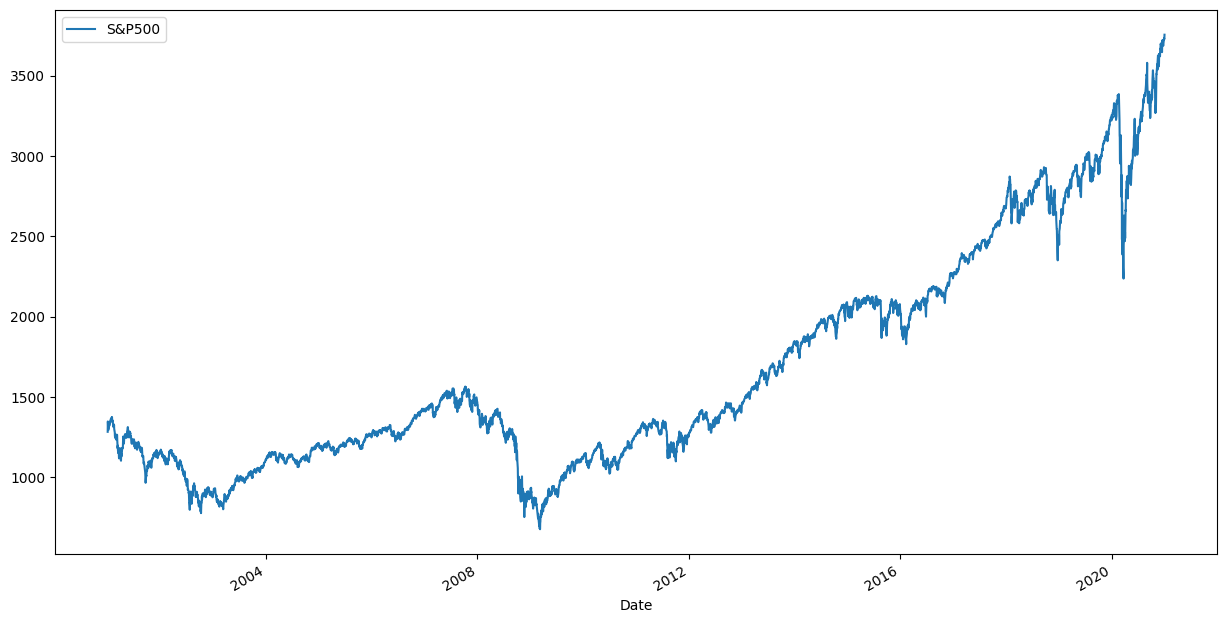

In [ ]:
_ = prices.plot(figsize=(15, 8))

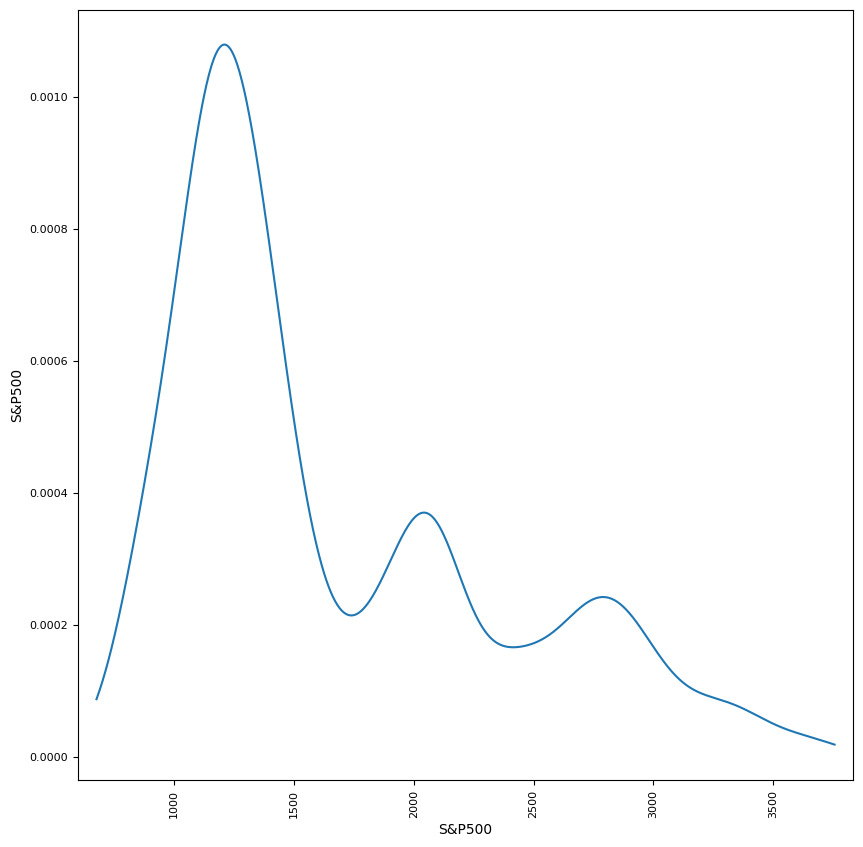

In [ ]:
_ = scatter_matrix(prices, figsize=(10, 10), diagonal='kde')

##### Log returns

In [ ]:
log_returns.describe()

,Log Returns
count,5032.000000
mean,0.021343
std,1.246941
min,-12.765220
25%,-0.451760
50%,0.065097
75%,0.571639
max,10.957197


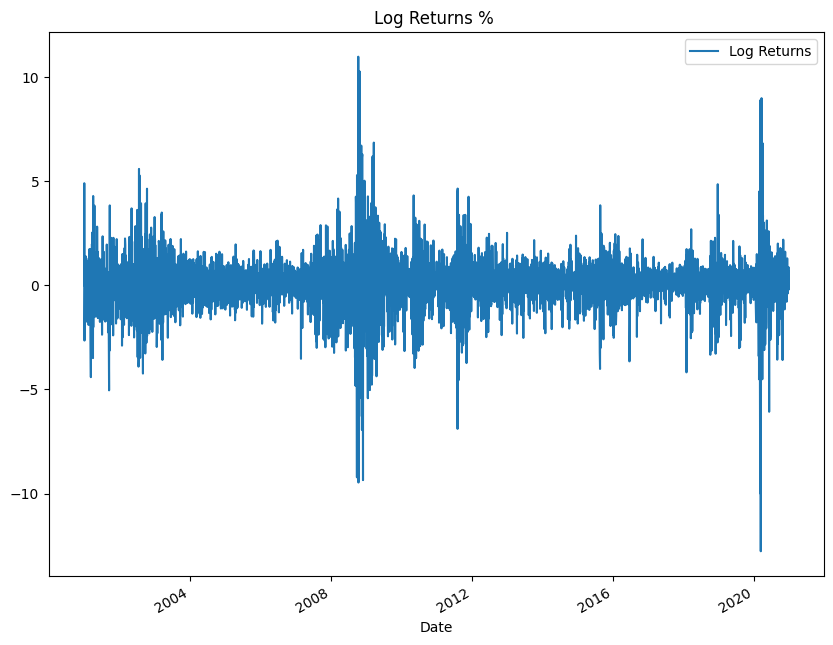

In [ ]:
_ = log_returns.plot(figsize=(10, 8), title = "Log Returns % ")

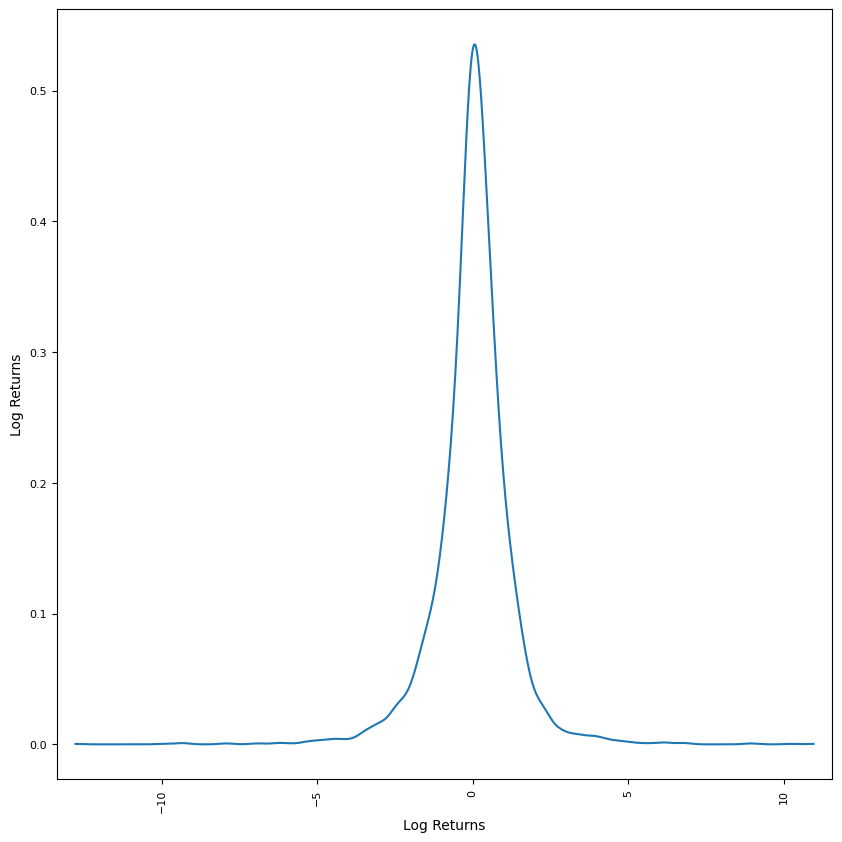

In [ ]:
_ = scatter_matrix(log_returns, figsize=(10, 10), diagonal='kde')

In [ ]:
def autocorrelation_plt(dataframe):
  
  """
  Function to compute autocorrelation plot 

  :param dataframe: dataframe (of floats) of time-series
  :output: plot with y axis as autocorrelation and x axis as lag
  """

  fig = plt.figure()
  fig.set_figwidth(10)
  fig.set_figheight(8)

  for i in dataframe:
    _ = autocorrelation_plot(dataframe[i], label=i)
  _ = plt.legend(loc='upper right')

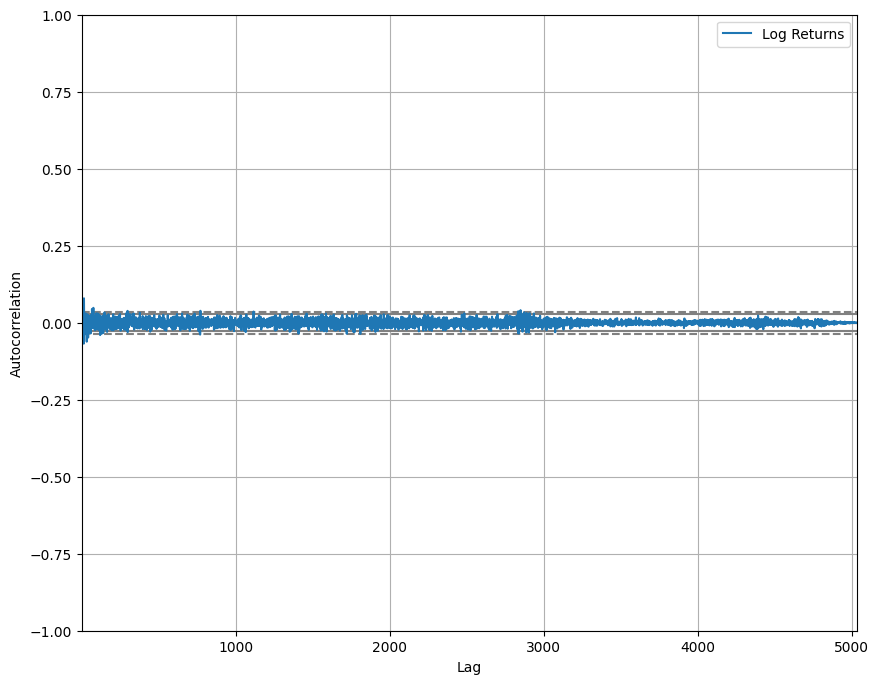

In [ ]:
# Auto correlation of log returns 
# Assumed to be close to zero for real time series (linear unpredictability)
autocorrelation_plt(log_returns) 

In [ ]:
# Cross correlation
log_returns.corr().iloc[:,0]

Log Returns    1.0
Name: Log Returns, dtype: float64

### Transform Data and Convert to Tensor

In [ ]:
# Rolling window applied to dataframe before converting it to tensor
def rolling_window(data, window=32, stride=1): 
    """
    takes an array and returns rolling window of inputs

    :data: array of values
    :window: size of window you would like each return input
    :stride: do we want to stride inputs 
    
    :return: array of windows
    """    
    x = []
    current = 0
    total = (len(data)/stride)-window
    for i in range(int(total)+1):
        x.append(data[current:current+window])
        current += stride
    return x

data = rolling_window(np.asarray(log_returns[:3000]))  # We only train the model on the first 3000 data points because the goal is to see
                                                       # whether we can generate 3000 data points long time series and train a prediction
                                                       # model on it that is as good as if we had trained it on 3000 real data points
train_data = np.stack(data, axis=0)

# Convert to tensor
train_data = tf.convert_to_tensor(train_data, np.float32)
train_dataset = tf.data.Dataset.from_tensor_slices(train_data).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

## Train the model

In [ ]:
# Global variables for the loss
G_loss, D_loss = [], []

In [ ]:
# Train the data
# EPOCHS = 200
# train(train_dataset, EPOCHS, choice)

Note to self: the generator loss value isn't indicative of the quality of the time series generated when comparing different models.

### Mode collapse and vanishing gradient problems

A common problem when training GAN networks is mode collapse. To cite the review of GANs in Finance: "Mode collapse is a failure mode of GANs that happens due to a deficiency in training. It can happen when the Generator maps several noise input-values to the same output region, or when the Generator ignores a region of the target data distribution. This means that if the Generator gets stuck in a local minimum generating limited samples, the Discriminator will eventually learn to differentiate the Generator’s fakes, ending the learning process and leading to an undiversified output. This is a problem because in generative modelling, the goal is not only to create realistic looking samples, but also to be able to produce a wider variety of samples."

Another common problem is the vanishing gradient problem: "The ongoing GAN research has shown that when the Discriminator gets too good, the training of the Generator can fail. The reason is that an optimal Discriminator doesn’t provide sufficient feedback for the Generator to properly learn. This is called the vanishing gradient problem, when the gradient gets so small that in backpropagation it does not change the weight values of the Generator’s initial layers, so their learning can get very slow and eventually come to a halt."

This is what happens most often when choosing the fin_gan model and this is why we switched to the quant_gan model instead, the st_gan model only producing time series of poor quality.

### Save the model

In [ ]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                  discriminator_optimizer=discriminator_optimizer,
                                  generator=generator,
                                  discriminator=discriminator)
#checkpoint.save(file_prefix=checkpoint_prefix)
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir+'_quantgan'))

## Evaluate the model


### KS-Test

This tests whether 2 samples are drawn from the same distribution. Note that the distribution is assumed to be continuous.

This is the two-sided test, one-sided tests are not implemented. The test uses the two-sided asymptotic Kolmogorov-Smirnov distribution.

If the K-S statistic is small or the p-value is high, then we cannot reject the hypothesis that the distributions of the two samples are the same.

In [ ]:
# Using the trained generator to compute new synthetic data
def generate_data():
    noise = np.random.randn(157,100)
    predictions = generator(noise, training=True)

    result = tf.squeeze(predictions) # Given a tensor input, this operation returns a tensor of the same type with all dimensions of size 1 removed
    temp = (result.numpy())
    generated_data = [item for sublist in temp for item in sublist] # temp is the list getting flattened
    
    return generated_data

generated_data = generate_data()
min_length = min(len(generated_data), len(prices))
generated_data = generated_data[:min_length]
df_generated = pd.DataFrame(generated_data, columns = ['logreturns'])
prices = prices[:min_length]
log_returns = log_returns[:min_length]

In [ ]:
stats.ks_2samp(log_returns.iloc[:,0],generated_data) # comparing real data to synthetic data

KstestResult(statistic=0.037818471337579616, pvalue=0.0015134543347601873, statistic_location=-0.22709901630878448, statistic_sign=-1)

### Plots

#### Generated vs Original time series

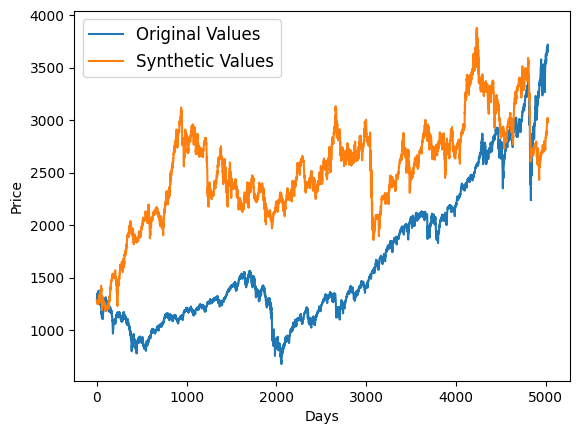

In [ ]:
def log_returns_to_normal_returns(generated_data, price0):
    df1 = pd.DataFrame(generated_data,columns=['Generated Data'])
    df2 = df1.div(100) # divide by 100 to compensate for training input (x100)
    df2.iloc[0, 0] = 0
    df3 = pd.DataFrame(df2.iloc[:,0].to_list(), columns = ['logreturns'])
    df3["logr_na0"] = df3.logreturns.fillna(0)
    df3['cumlog'] = np.cumsum(df3.logr_na0)
    df3["norm"] = np.exp(df3.cumlog)
    df3["prices_back"] = price0 * df3.norm
    
    return df3.iloc[:,4].tolist()

price0 = prices.iloc[0,0]
list_generated = log_returns_to_normal_returns(generated_data, price0)
list_original = prices.iloc[:,0].tolist()
plt.plot(list_original, label= "Original Values")
plt.plot(list_generated, label= "Synthetic Values")
plt.xlabel("Days")
plt.ylabel("Price")
plt.legend(fontsize=12)
plt.show()

We have generated a realistic time series !

#### Generated vs Original log returns

By looking at the log-returns plot from the S&P 500 (figure 7), it is possible to recognize some key patterns. Firstly, the limit in which the returns fluctuate, centered at zero and staying between -10% and 10%. 
Second, the clusters of periods with high volatility and low volatility are usually bundled together, as asserted by the stylized fact of volatility clustering. This pattern is visually identifiable, and it is expected that a good synthetic sample resemble the original data by repeating this patterns of clusters.



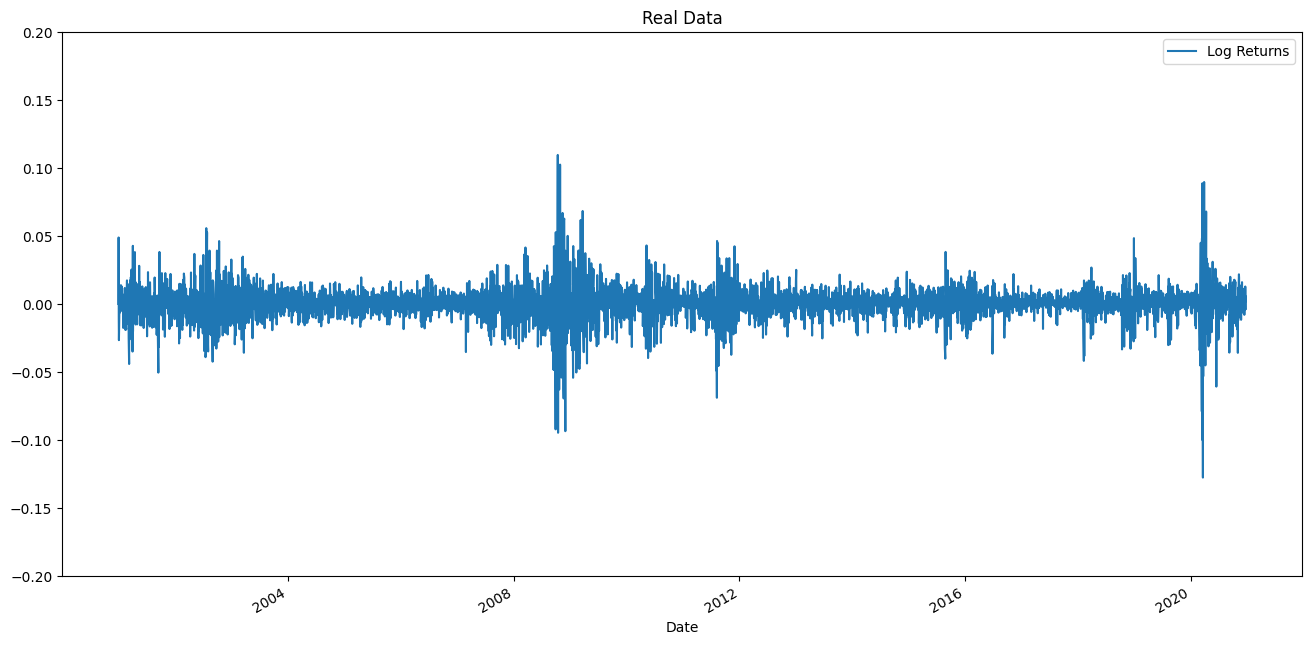

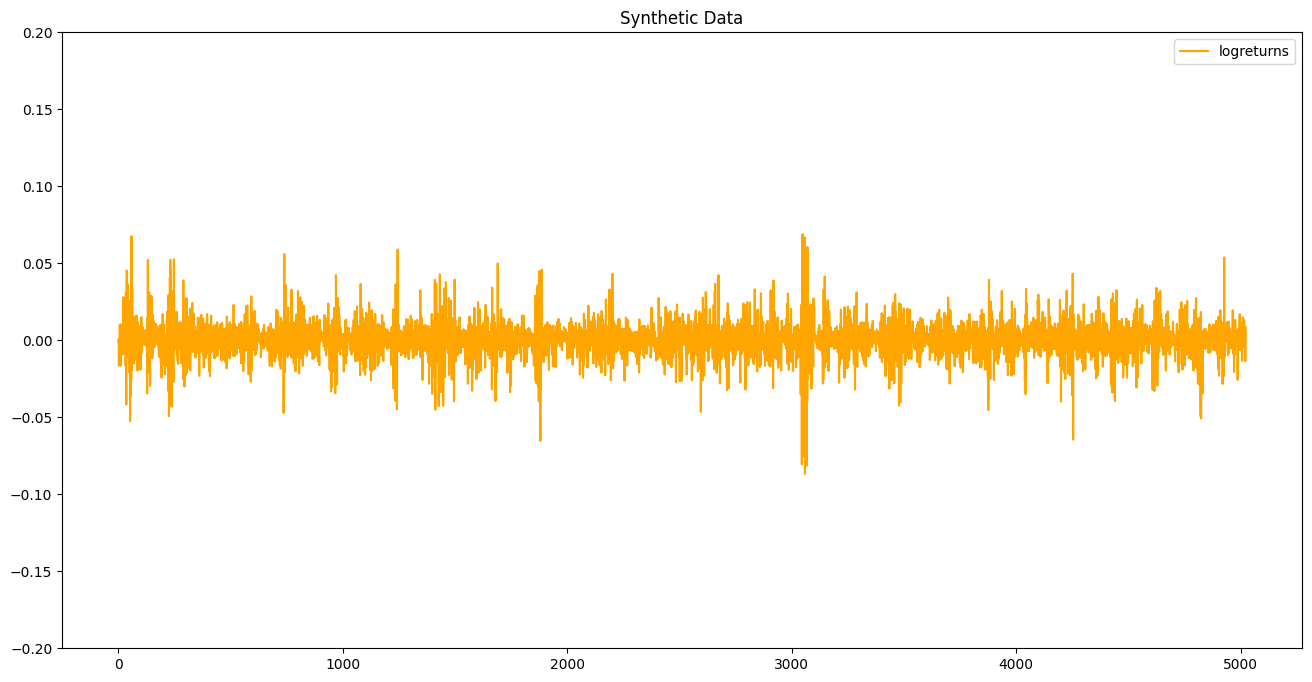

In [ ]:
log_returns.div(100).plot(title = "Real Data",ylim=[-0.2,0.2],figsize=(16, 8))
df_generated.div(100).plot(title = "Synthetic Data",ylim=[-0.2,0.2],style="orange",figsize=(16, 8))
plt.show()

#### Auto-correlation

The auto-correlation plots show the similarity between observations as a function of time lags between them, for financial returns the autocorrelation it is expected to be very low, given the stylized fact of linear unpredictability.


(0.0, 2000.0)

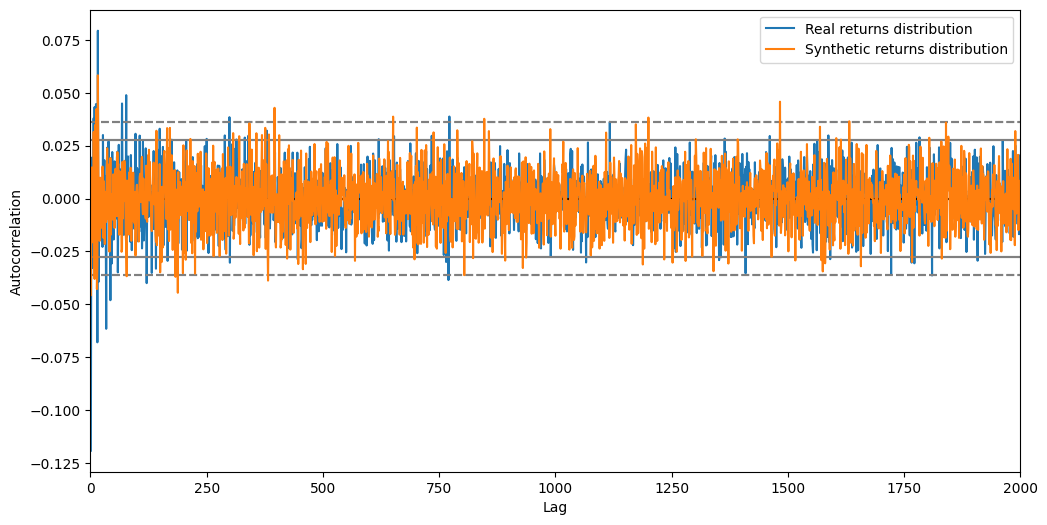

In [ ]:
#ACF 
fig, (ax2) = plt.subplots(1, 1, figsize=(12,6))
pd.plotting.autocorrelation_plot(log_returns,label='Real returns distribution', ax=ax2).set_xlim([0, 2000])
pd.plotting.autocorrelation_plot(generated_data, ax=ax2,label='Synthetic returns distribution').set_xlim([0, 2000])

(0.0, 2000.0)

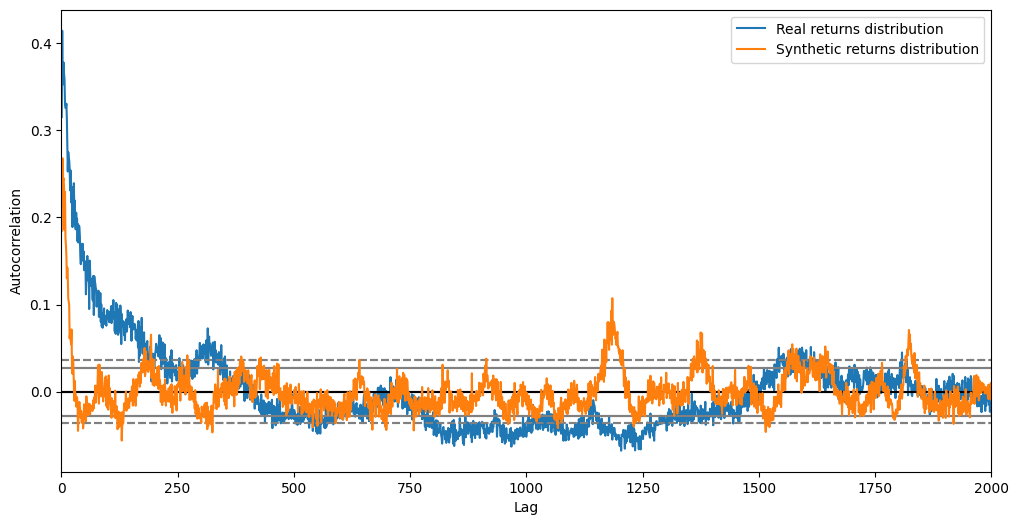

In [ ]:
# ACF of absolute returns
fig, (ax2) = plt.subplots(1, 1, figsize=(12,6))
pd.plotting.autocorrelation_plot(np.abs(log_returns),label='Real returns distribution', ax=ax2).set_xlim([0, 2000])
pd.plotting.autocorrelation_plot(np.abs(generated_data), ax=ax2,label='Synthetic returns distribution').set_xlim([0, 2000])

#### Skewness and Kurtosis

Here the generated and real returns are displayed to analyze their distribution and its characteristic skewness and kurtosis measurements. 

For a GAN to be qualified as good, it is expected that the synthetic returns distribution resemble the shape of the normal distribution (aggregational gaussianity) and the values for skewness and kurtosis should be close to those from real returns.






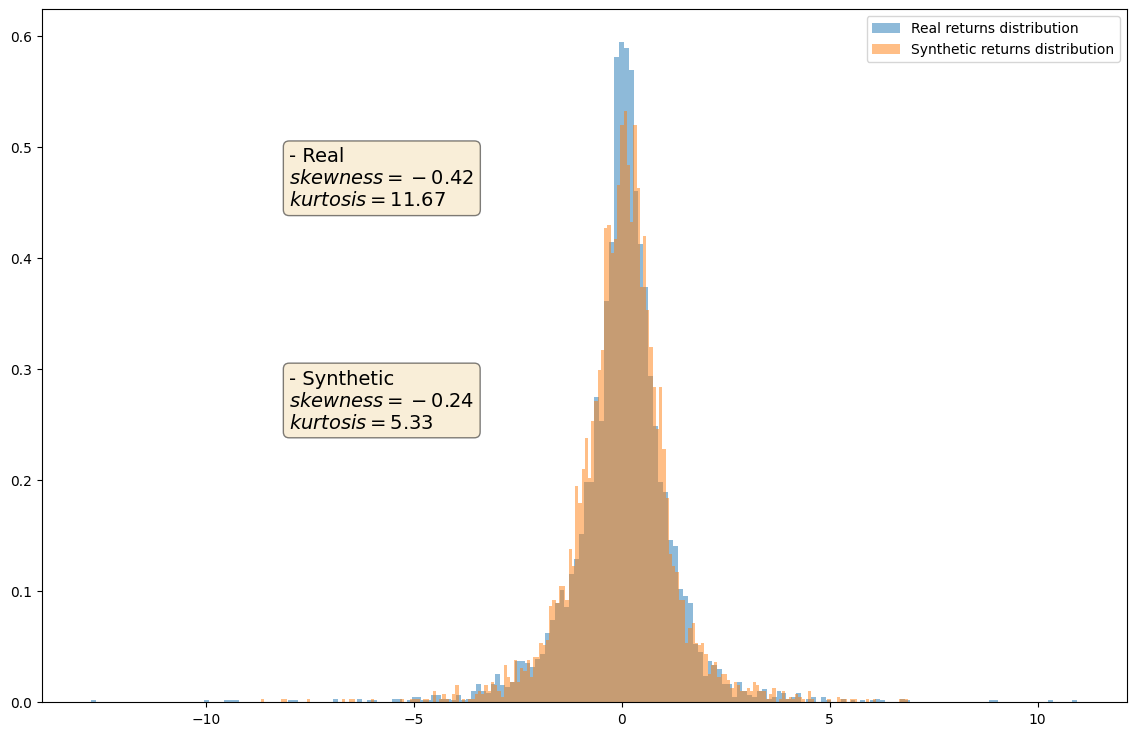

In [ ]:
# Comparing the distribution of real and generated (synthetic) data
# PDFs show the probability of observing a value within a specific range
def empirical_pdf(real, syntethic):
  fig, (ax2) = plt.subplots(1, 1, figsize=(14,9))
  ax2.hist(real, density=True, bins=200,alpha=0.5,label='Real returns distribution')
  ax2.hist(syntethic, density=True, bins=200,alpha=0.5,label='Synthetic returns distribution')
  ax2.legend(loc='upper right')

  textstr = '\n'.join((
      r'%s' % ("- Real",),
      # t'abs_metric=%.2f' % abs_metric
      r'$skewness=%.2f$' % (skew(real),),
      r'$kurtosis=%.2f$' % (kurtosis(real),))
  )
  props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
  ax2.text(
      -8, 0.5, textstr,
      fontsize=14,
      verticalalignment='top',
      bbox=props
  )
  textstr = '\n'.join((
      r'%s' % ("- Synthetic",),
      # t'abs_metric=%.2f' % abs_metric
      r'$skewness=%.2f$' % (skew(syntethic),),
      r'$kurtosis=%.2f$' % (kurtosis(syntethic),))
  )
  ax2.text(
      -8, 0.3, textstr, 
      fontsize=14,
      verticalalignment='top',
      bbox=props
  )

empirical_pdf(log_returns.iloc[:,0], generated_data)

**Skewness** is a measure of the asymmetry of the probability distribution of a real-valued random variable about its mean. Here it portrays the gain/loss asymmetry of log returns, where it is expected that the skewness be negative, since it is more common to have large downwards movements in stock prices then the contrary.


**Kurtosis** is a measure that defines how much the tails of a given distribution differ from the tails of a normal distribution. It identifies whether there are extreme values in the tails of a distribution. For returns, large values for kurtosis (heavy tails) are expected, since some low probability events have a large impact on the distribution. This behaviour does not happen in a normal distribution, so returns are expected to have the rough shape of a normal distribution, but with much heavier tails.


# Financial Time Series Prediction With LSTMs

## Setup

### Installing libraries

In [ ]:
%pip install scikit-learn
%pip install keras

### Importing libraries

In [ ]:
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from sklearn.metrics import mean_squared_error

### Hyperparameters

In [ ]:
ltms_num = 60  # number of long-term memory states

## Plot the synthetic and real training set again

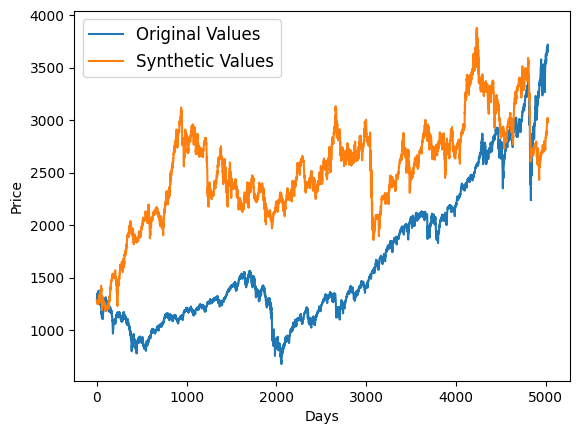

In [ ]:
plt.plot(list_original, label= "Original Values")
plt.plot(list_generated, label= "Synthetic Values")
plt.xlabel("Days")
plt.ylabel("Price")
plt.legend(fontsize=12)
plt.show()

## Preprocess the data

In [ ]:
synth_training_set = [[x] for x in list_generated[:3000]]
real_training_set = [[x] for x in list_original[:3000]]
test_set =  [[x] for x in list_original[3000:3660]]

In [ ]:
sc = MinMaxScaler(feature_range=(0,1))

def process_training_set(training_set):

    global sc

    # Scaling the training set
    training_set_scaled = sc.fit_transform(training_set)

    # Preparing the training set
    # Since LSTMs store long term memory states, we create a data structure with 60 timesteps and 1 output
    # So for each element of the training set, we have 60 previous elements of the training set

    X_train = []
    y_train = []
    for i in range(ltms_num,len(training_set)):
        X_train.append(training_set_scaled[i-ltms_num:i,0])
        y_train.append(training_set_scaled[i,0])
    X_train, y_train = np.array(X_train), np.array(y_train)

    # Reshaping X_train for efficient modelling
    X_train = np.reshape(X_train, (X_train.shape[0],X_train.shape[1],1))

    return X_train, y_train

In [ ]:
X_train_synth, y_train_synth = process_training_set(synth_training_set)
X_train_real, y_train_real = process_training_set(real_training_set)

In [ ]:
# Scaling the test set
test_set_scaled  = sc.transform(test_set)

# Preparing the test set
X_test = []
for i in range(ltms_num,len(test_set)):
    X_test.append(test_set_scaled[i-ltms_num:i,0])
X_test = np.array(X_test)

# Reshaping X_test for efficient predicting
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))

## Create the LSTM model

In [ ]:
def make_model(n):

    # The LSTM architecture
    regressor = Sequential()

    # First LSTM layer with Dropout regularisation
    regressor.add(LSTM(units=50, return_sequences=True, input_shape=(n,1)))
    regressor.add(Dropout(0.2))

    # Second LSTM layer
    regressor.add(LSTM(units=50, return_sequences=True))
    regressor.add(Dropout(0.2))

    # Third LSTM layer
    regressor.add(LSTM(units=50, return_sequences=True))
    regressor.add(Dropout(0.2))

    # Fourth LSTM layer
    regressor.add(LSTM(units=50))
    regressor.add(Dropout(0.2))
    
    # The output layer
    regressor.add(Dense(units=1))

    # Compiling the RNN
    regressor.compile(optimizer='adam',loss='mean_squared_error')

    return regressor

In [ ]:
n = X_train_synth.shape[1]
regressor1 = make_model(n)

## Train the model on synthetic data

In [ ]:
# Fitting to the training set. This cell should take maximum 15min to run
regressor1.fit(X_train_synth, y_train_synth, epochs=100, batch_size=32, verbose=0)

## Evaluate the model on synthetic data

### Predict

In [ ]:
predicted_stock_prices_scaled1 = regressor1.predict(X_test)
predicted_stock_prices1 = sc.inverse_transform(predicted_stock_prices_scaled1)

18/18 [==============================] - 0s 12ms/step


### RMSE

In [ ]:
def return_rmse(test,predicted):
    rmse = math.sqrt(mean_squared_error(test, predicted))
    print("The root mean squared error is {}.".format(rmse))

In [ ]:
# Evaluate the model
return_rmse(test_set[ltms_num:],predicted_stock_prices1)

The root mean squared error is 31.532849372262056.


### Plot

In [ ]:
# Visualizing the results
def plot_predictions(test, predicted):
    plt.plot(test, color='red',label='Real S&P500 Price')
    plt.plot(predicted, color='blue',label='Predicted S&P500 Price')
    plt.title('S&P500 Price Prediction')
    plt.xlabel('Days')
    plt.legend()
    plt.show()

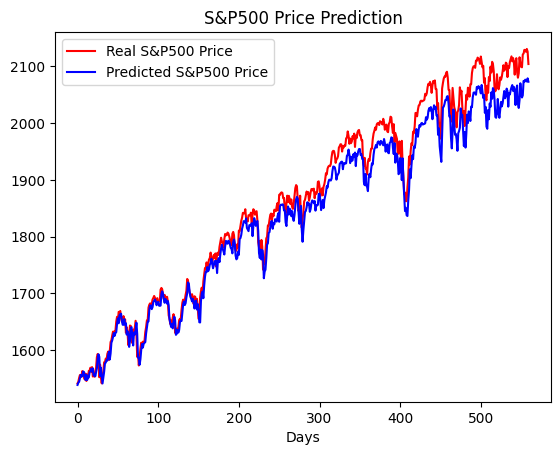

In [ ]:
# Visualizing the results
plot_predictions(test_set[ltms_num:], predicted_stock_prices1)

## Evaluate the model on real data

### Create and train the model on real data

In [ ]:
n = X_train_real.shape[1]
regressor2 = make_model(n)

In [ ]:
# Fitting to the training set. This cell should take maximmum 15min to run
regressor2.fit(X_train_real, y_train_real, epochs=100, batch_size=32, verbose=0)

### Predict

In [ ]:
predicted_stock_prices_scaled2 = regressor2.predict(X_test)
predicted_stock_prices2 = sc.inverse_transform(predicted_stock_prices_scaled2)

18/18 [==============================] - 0s 10ms/step


### RMSE

In [ ]:
# Evaluate the model
return_rmse(test_set[ltms_num:],predicted_stock_prices2)

The root mean squared error is 92.1706131900494.


### Plot

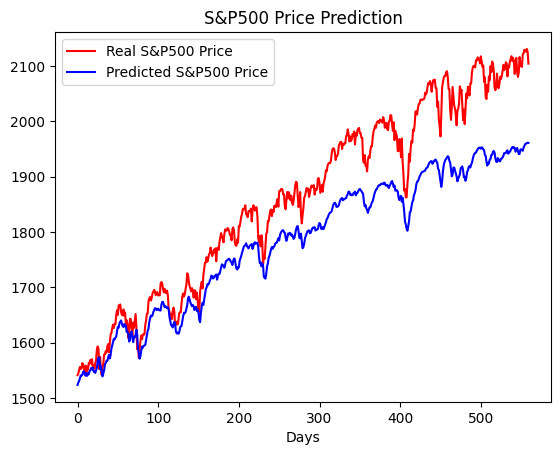

In [ ]:
# Visualizing the results
plot_predictions(test_set[ltms_num:], predicted_stock_prices2)

## Conclusion

What we have showed, is that we can train Generative Adversarial Network on a dataset of 3000 data points to generate time series that are on par with real time series. Indeed, when training an LSTM model on the generated time series, we were able to achieve even better precision (33% better actually) than had the model been trained on a real time series.